## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras
import tensorflow as tf
# 本範例不需使用 GPU, 將 GPU 設定為 "無"
# 使用第一張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = " 0 "
# 只使用 60% 的 GPU 記憶體
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# 設定 Keras 使用的 TensorFlow Session
tf.keras.backend.set_session(sess)

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    # 資料前處理 - 標準化
    x = x / 255.
    if flatten:
        # 將資料從圖形 (RGB) 轉為向量 (Single Vector)
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        # 用np_utils裡的to_categorical來做one-hot encoding的轉換：
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x) # 加入Batch Normalization，能夠將每一層的輸入/輸出做正規化
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)# 加入Batch Normalization，能夠將每一層的輸入/輸出做正規化
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3 # 學習率
EPOCHS = 50 # 訓練50週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
BATCH_SIZE = 1024 # 訓練時每個批次的樣本數。訓練樣本數/批次樣本數 = 批次數（每個週期）
MOMENTUM = 0.95 # 動量

In [14]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint

model_ckpt1 = ModelCheckpoint(filepath="./tmp1.h5", # 保存模型的路徑
                             monitor="val_loss",  # 監控數據的接口
                             save_best_only=True) # save best checkpoint
                             # 若設置為True，則只保存模型權重，否則將保存整个模型（包括模型結構，配置訊息等）

model_ckpt2 = ModelCheckpoint(filepath="./tmp2.h5", # 保存模型的路徑
                             monitor="val_loss",  # 監控數據的接口
                             save_best_only=False) # save best checkpoint
                             # 若設置為True，則只保存模型權重，否則將保存整个模型（包括模型結構，配置訊息等）
    
model_ckpt = ['model_ckpt1','model_ckpt2']

    
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for mckpt in model_ckpt:
    if mckpt == 'model_ckpt1':
        keras.backend.clear_session()
        print("Experiment with %s" % (mckpt))
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, # 訓練資料。
                  epochs=EPOCHS, # 訓練EPOCHS週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
                  batch_size=BATCH_SIZE, # 訓練時每個批次的樣本數，訓練樣本數/批次樣本數 = 批次數（每個週期）
                  validation_data=(x_test, y_test),  # 驗證資料。
                  shuffle=True, # 每次epochs後，將訓練集打亂順序。
                  callbacks=[model_ckpt1]
                 )
    else:
        keras.backend.clear_session()
        print("Experiment with %s" % (mckpt))
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, # 訓練資料。
                  epochs=EPOCHS, # 訓練EPOCHS週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
                  batch_size=BATCH_SIZE, # 訓練時每個批次的樣本數，訓練樣本數/批次樣本數 = 批次數（每個週期）
                  validation_data=(x_test, y_test),  # 驗證資料。
                  shuffle=True, # 每次epochs後，將訓練集打亂順序。
                  callbacks=[model_ckpt2]
                 )
        
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-%s" % str(mckpt)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-accuracy': train_acc,
                             'valid-accuracy': valid_acc}

# Load back1
model1 = keras.models.load_model("./tmp1.h5")
loss_loadback1, acc_loadback1 = model.evaluate(x_test, y_test)
# Load back2
model2 = keras.models.load_model("./tmp2.h5")
loss_loadback2, acc_loadback2 = model.evaluate(x_test, y_test)

Experiment with model_ckpt1
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (N

50000/50000 [==============================] - 2s 38us/step - loss: 0.6530 - accuracy: 0.8011 - val_loss: 1.5704 - val_accuracy: 0.4914
Epoch 42/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.6347 - accuracy: 0.8082 - val_loss: 1.6084 - val_accuracy: 0.4863
Epoch 43/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.6163 - accuracy: 0.8151 - val_loss: 1.6213 - val_accuracy: 0.4842
Epoch 44/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.5990 - accuracy: 0.8217 - val_loss: 1.6044 - val_accuracy: 0.4853
Epoch 45/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.5808 - accuracy: 0.8282 - val_loss: 1.6165 - val_accuracy: 0.4860
Epoch 46/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.5650 - accuracy: 0.8353 - val_loss: 1.6380 - val_accuracy: 0.4808
Epoch 47/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.5469 - accuracy: 0.8414 - val_loss: 1.6798

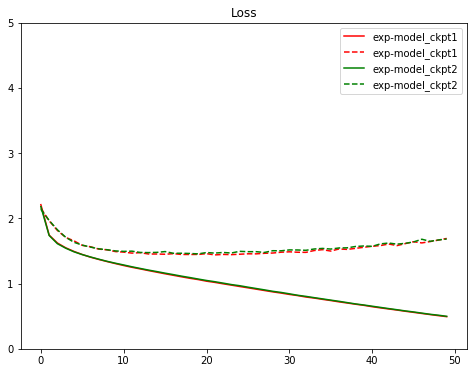

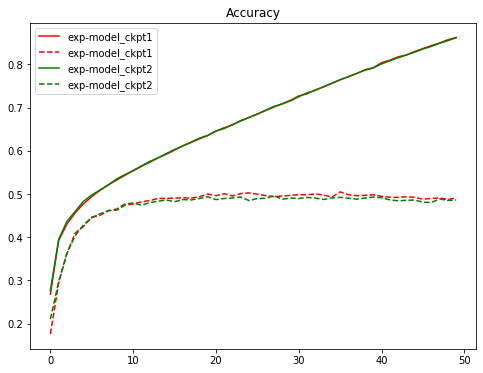

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-accuracy'])),results[cond]['train-accuracy'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-accuracy'])),results[cond]['valid-accuracy'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [16]:
print(acc_loadback1, acc_loadback2)

0.4860000014305115 0.4860000014305115
